In [21]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
%matplotlib inline

In [22]:
yahoo_db = '/home/ian/Data/yahoo.db'
tmx_db = '/home/ian/Data/tmx.db'
advfn_db = '/home/ian/Data/advfn.db'

yahoo_database = sqlite3.connect(yahoo_db)
tmx_database = sqlite3.connect(tmx_db)
advfn_database = sqlite3.connect(advfn_db)


In [34]:
tmx_sql = '''SELECT date, eps FROM tmx_earnings WHERE symbol = "BNS"'''
df_tmx = pd.read_sql_query(tmx_sql, tmx_database)
df_tmx.columns = ['date', 'eps']
df_tmx['date_parsed'] = df_tmx['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_tmx.drop(columns = 'date', inplace = True)

aav_sql = '''SELECT Date, Close FROM aav_prices WHERE symbol = "BNS" AND close != "null"'''
df_aav = pd.read_sql_query(aav_sql, yahoo_database)
df_aav.columns = ['date', 'close']
df_aav['date_parsed'] = df_aav['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_aav.drop(columns = 'date', inplace = True)

yahoo_prices_sql = '''SELECT Date, Close FROM tsx_prices WHERE symbol = "BNS" AND close != "null"'''
df_y_price = pd.read_sql_query(yahoo_prices_sql, yahoo_database)
df_y_price.columns = ['date', 'close']
df_y_price['date_parsed'] = df_y_price['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_y_price.drop(columns = 'date', inplace = True)

divs_sql = '''SELECT Date, Dividends, split_factor FROM divs WHERE symbol = "BNS"'''
df_divs = pd.read_sql_query(divs_sql, yahoo_database) 
df_divs.columns = ['date', 'div', 'split_factor']
df_divs['date_parsed'] = df_divs['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_divs.drop(columns = 'date', inplace = True)



In [35]:
df_price = pd.concat([df_y_price, df_aav])
print('Before: ' + str(df_price.shape[0]))
df_price.drop_duplicates(subset='date_parsed', inplace = True)
print('After: ' + str(df_price.shape[0]))
df_price

Before: 6220
After: 6121


,close,date_parsed
0,6.1575,1995-01-12
1,6.2500,1995-01-13
2,6.3750,1995-01-16
3,6.2825,1995-01-17
4,6.3450,1995-01-18
5,6.3125,1995-01-19
6,6.1875,1995-01-20
7,6.1575,1995-01-23
8,6.2825,1995-01-24
9,6.3450,1995-01-25


In [36]:
df = df_price.join(df_tmx.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

In [37]:
df = df.join(df_divs.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

In [38]:
df.fillna(method='ffill', inplace = True)

df.set_index(df['date_parsed'], inplace= True)
df.head(5)

,close,date_parsed,eps,div,split_factor
date_parsed,,,,,
1994-11-30,NaN,1994-11-30,0.2025,NaN,NaN
1995-01-12,6.1575,1995-01-12,0.2025,NaN,NaN
1995-01-13,6.2500,1995-01-13,0.2025,NaN,NaN
1995-01-16,6.3750,1995-01-16,0.2025,NaN,NaN
1995-01-17,6.2825,1995-01-17,0.2025,NaN,NaN


In [39]:
#this is for current quarter only - go back and fill the TTM on df_earnings and df_divs
df['pe'] = 0.0
df['dy'] = 0.0

In [40]:
def process_row(row):
    if (row['close'] != row['close']) | (row['close'] == 'null'):
        df.at[row['date_parsed'], 'pe'] = np.NaN
        df.at[row['date_parsed'], 'dy'] = np.NaN
        return
    if row['eps'] == row['eps']:
        if row['eps'] == 0:
            df.at[row['date_parsed'], 'pe'] = np.NaN
        else:
            df.at[row['date_parsed'], 'pe'] = float(row['close']) / (4*row['eps'])
    
    if row['eps'] == row['eps']:
        if row['close'] == 0:
            df.at[row['date_parsed'], 'dy'] = np.NaN
        else:
            df.at[row['date_parsed'], 'dy'] = 4* row['div'] / (float(row['close']) * row['split_factor'])
        
    
    

In [41]:
df.apply(process_row, axis = 1)


,close,date_parsed,eps,div,split_factor,pe,dy
date_parsed,,,,,,,
1994-11-30,NaN,1994-11-30,0.2025,NaN,NaN,NaN,NaN
1995-01-12,6.1575,1995-01-12,0.2025,NaN,NaN,7.601852,NaN
1995-01-13,6.2500,1995-01-13,0.2025,NaN,NaN,7.716049,NaN
1995-01-16,6.3750,1995-01-16,0.2025,NaN,NaN,7.870370,NaN
1995-01-17,6.2825,1995-01-17,0.2025,NaN,NaN,7.756173,NaN
1995-01-18,6.3450,1995-01-18,0.2025,NaN,NaN,7.833333,NaN
1995-01-19,6.3125,1995-01-19,0.2025,NaN,NaN,7.793210,NaN
1995-01-20,6.1875,1995-01-20,0.2025,NaN,NaN,7.638889,NaN
1995-01-23,6.1575,1995-01-23,0.2025,NaN,NaN,7.601852,NaN


In [50]:
df.at['1994-11-30', 'close'] = 6.1575


,close,date_parsed,eps,div,split_factor,pe,dy,avg_50,avg_200
date_parsed,,,,,,,,,
1994-11-30,6.1575,1994-11-30,0.2025,NaN,NaN,NaN,NaN,NaN,NaN
1995-01-12,6.1575,1995-01-12,0.2025,NaN,NaN,7.601852,NaN,NaN,NaN
1995-01-13,6.2500,1995-01-13,0.2025,NaN,NaN,7.716049,NaN,NaN,NaN
1995-01-16,6.3750,1995-01-16,0.2025,NaN,NaN,7.870370,NaN,NaN,NaN
1995-01-17,6.2825,1995-01-17,0.2025,NaN,NaN,7.756173,NaN,NaN,NaN
1995-01-18,6.3450,1995-01-18,0.2025,NaN,NaN,7.833333,NaN,NaN,NaN
1995-01-19,6.3125,1995-01-19,0.2025,NaN,NaN,7.793210,NaN,NaN,NaN
1995-01-20,6.1875,1995-01-20,0.2025,NaN,NaN,7.638889,NaN,NaN,NaN
1995-01-23,6.1575,1995-01-23,0.2025,NaN,NaN,7.601852,NaN,NaN,NaN


In [55]:
df

,close,date_parsed,eps,div,split_factor,pe,dy,avg_50,avg_200
date_parsed,,,,,,,,,
1994-11-30,6.1575,1994-11-30,0.2025,NaN,NaN,NaN,NaN,15.868894,8.802583
1995-01-12,6.1575,1995-01-12,0.2025,NaN,NaN,7.601852,NaN,14.490919,8.726653
1995-01-13,6.2500,1995-01-13,0.2025,NaN,NaN,7.716049,NaN,13.190835,8.651948
1995-01-16,6.3750,1995-01-16,0.2025,NaN,NaN,7.870370,NaN,11.985518,8.578475
1995-01-17,6.2825,1995-01-17,0.2025,NaN,NaN,7.756173,NaN,10.890469,8.506543
1995-01-18,6.3450,1995-01-18,0.2025,NaN,NaN,7.833333,NaN,9.918576,8.435975
1995-01-19,6.3125,1995-01-19,0.2025,NaN,NaN,7.793210,NaN,9.078969,8.366809
1995-01-20,6.1875,1995-01-20,0.2025,NaN,NaN,7.638889,NaN,8.375307,8.299156
1995-01-23,6.1575,1995-01-23,0.2025,NaN,NaN,7.601852,NaN,7.805719,8.233003


In [31]:
kern_200 = [0.000001,0.000001,0.000001,0.000001,0.000001,0.000002,0.000002,0.000002,0.000003,0.000003,0.000004,0.000005,0.000006,0.000007,0.000009,0.00001,0.000012,0.000015,0.000017,0.000021,0.000024,0.000029,0.000034,0.00004,0.000047,0.000054,0.000063,0.000074,0.000086,0.000099,0.000115,0.000133,0.000153,0.000176,0.000202,0.000231,0.000264,0.000301,0.000342,0.000388,0.00044,0.000498,0.000562,0.000632,0.000711,0.000797,0.000892,0.000996,0.00111,0.001235,0.001371,0.001519,0.001679,0.001852,0.002038,0.002239,0.002455,0.002686,0.002932,0.003194,0.003473,0.003769,0.00408,0.004409,0.004754,0.005116,0.005494,0.005888,0.006297,0.00672,0.007157,0.007607,0.008068,0.00854,0.00902,0.009508,0.010002,0.010499,0.010999,0.011498,0.011996,0.012489,0.012975,0.013453,0.013919,0.014372,0.014809,0.015228,0.015626,0.016002,0.016353,0.016677,0.016972,0.017237,0.01747,0.01767,0.017835,0.017964,0.018058,0.018114,0.018132,0.018114,0.018058,0.017964,0.017835,0.01767,0.01747,0.017237,0.016972,0.016677,0.016353,0.016002,0.015626,0.015228,0.014809,0.014372,0.013919,0.013453,0.012975,0.012489,0.011996,0.011498,0.010999,0.010499,0.010002,0.009508,0.00902,0.00854,0.008068,0.007607,0.007157,0.00672,0.006297,0.005888,0.005494,0.005116,0.004754,0.004409,0.00408,0.003769,0.003473,0.003194,0.002932,0.002686,0.002455,0.002239,0.002038,0.001852,0.001679,0.001519,0.001371,0.001235,0.00111,0.000996,0.000892,0.000797,0.000711,0.000632,0.000562,0.000498,0.00044,0.000388,0.000342,0.000301,0.000264,0.000231,0.000202,0.000176,0.000153,0.000133,0.000115,0.000099,0.000086,0.000074,0.000063,0.000054,0.000047,0.00004,0.000034,0.000029,0.000024,0.000021,0.000017,0.000015,0.000012,0.00001,0.000009,0.000007,0.000006,0.000005,0.000004,0.000003,0.000003,0.000002,0.000002,0.000002,0.000001,0.000001,0.000001,0.000001,0.000001]
kern_50 =  [0,0.000001,0.000002,0.000005,0.000012,0.000027,0.00006,0.000125,0.000251,0.000484,0.000898,0.001601,0.002743,0.004514,0.00714,0.010852,0.015849,0.022242,0.029993,0.038866,0.048394,0.057904,0.066574,0.073551,0.078084,0.079656,0.078084,0.073551,0.066574,0.057904,0.048394,0.038866,0.029993,0.022242,0.015849,0.010852,0.00714,0.004514,0.002743,0.001601,0.000898,0.000484,0.000251,0.000125,0.00006,0.000027,0.000012,0.000005,0.000002,0.000001,0]

def custom_kernel(func, kern):
    '''
    Convolution of a function by a kernel.
    Kernel must be odd in length
    Function must be longer than kernel    
    '''
    if len(func) < len(kern):
        return func
    else:
        #midpoint of the kernel
        mid_kern = int((len(kern) + 1)/2)
        
    conv_func = np.zeros(len(func))
    
    for index, value in enumerate(func):
        
        ##TODO: this case is backwards I think
        if index < mid_kern:
            #go from kern[mid_kern] to end for zero
            dist_from_start = index -1
            kern_start = mid_kern - dist_from_start         
           
            sum = 0.0
            area = 0.0
            for i in range(kern_start, len(kern)):                
                sum += kern[i] * func[index + i - mid_kern]
                #need to correct for the area under the partial kernel being < 1
                area += kern[i]
            conv_func[index] = sum / area
            
        elif index > len(func) - mid_kern:         
            #go from zero to mid_kern + (distance to end of func)
            dist_to_end = len(func) - index + 1
            sum = 0.0
            area = 0.0
            for i in range(0, (mid_kern + dist_to_end -1)):
                sum += kern[i] * func[index + i - mid_kern]
                area += kern[i]
            conv_func[index] = sum / area   
            
        else:
            #sum of kernel * function over window of kernel length centered on func[index]
            sum = 0.0
            for kern_ind, kern_val in enumerate(kern):
                sum += kern_val * func[index + kern_ind - mid_kern]
            conv_func[index] = sum
        
    return conv_func


In [51]:
df['avg_50'] = custom_kernel(df['close'], kern_50)
df['avg_200'] = custom_kernel(df['close'], kern_200)

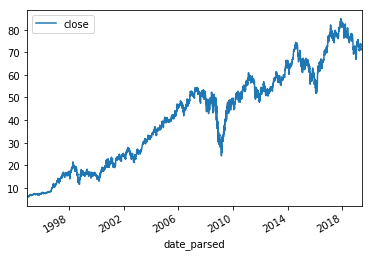

In [52]:
df.plot(x = 'date_parsed', y ='close')

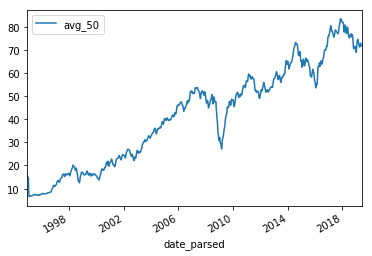

In [53]:
df.plot(x = 'date_parsed', y ='avg_50')

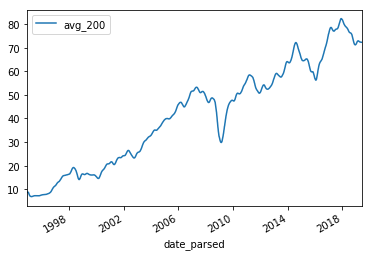

In [54]:
df.plot(x = 'date_parsed', y ='avg_200')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fc961a9e8>]],
      dtype=object)

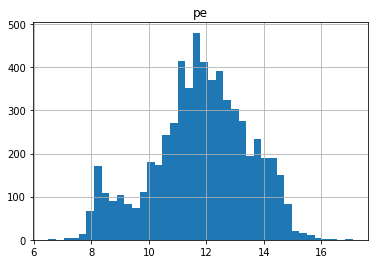

In [11]:
df.hist(['pe'], bins=40)


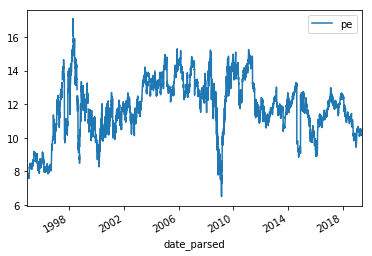

In [12]:
df.plot(x = 'date_parsed', y ='pe')

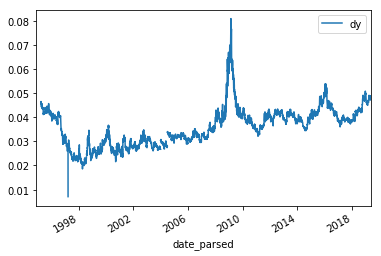

In [13]:
df.plot(x = 'date_parsed', y ='dy')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8fc7337eb8>]],
      dtype=object)

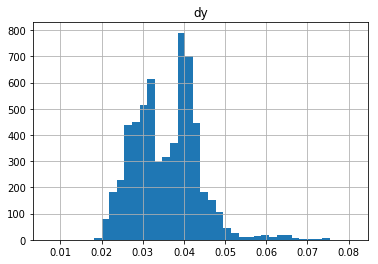

In [14]:
df.hist(['dy'], bins=40)

In [16]:
df['dy'].mean()

0.03584753429194877

In [17]:
df['pe'].mean()

11.798968627647056

In [ ]:
'''
TODO:
 - Split dates (date, factor)
 - Use TTM for p-e and yield where possible
 - 68/32, 95/5 for pe and dy
 - 68/32, 95/5 (sigma, 2sigma) pe and dy bands, and time series, for each quarter
 - 21-element and 201-element kernels on time series
 - ror to date
 - correlate ror to pe
 - correlate ror to dy
 - distribution of ror vs pe +- 5%
 - distribution of ror vs dy +- 5%
 - measure R^2 for ror to pe, ranks TSX composite
 
'''
